<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analysis-of-A/B-test-results" data-toc-modified-id="Analysis-of-A/B-test-results-1">Analysis of A/B test results</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1.1">Data preparation</a></span></li><li><span><a href="#1.-Cumulative-revenue-by-groups" data-toc-modified-id="1.-Cumulative-revenue-by-groups-1.2">1. Cumulative revenue by groups</a></span></li><li><span><a href="#2.-Cumulative-average-check-by-groups" data-toc-modified-id="2.-Cumulative-average-check-by-groups-1.3">2. Cumulative average check by groups</a></span><ul class="toc-item"><li><span><a href="#Relative-change-in-cumulative-average-check-of-group-B-to-group-A" data-toc-modified-id="Relative-change-in-cumulative-average-check-of-group-B-to-group-A-1.3.1">Relative change in cumulative average check of group B to group A</a></span></li></ul></li><li><span><a href="#3.-Cumulative-conversion-by-groups" data-toc-modified-id="3.-Cumulative-conversion-by-groups-1.4">3. Cumulative conversion by groups</a></span><ul class="toc-item"><li><span><a href="#Relative-change-in-cumulative-conversion-of-group-B-to-group-A" data-toc-modified-id="Relative-change-in-cumulative-conversion-of-group-B-to-group-A-1.4.1">Relative change in cumulative conversion of group B to group A</a></span></li></ul></li><li><span><a href="#4.-Amount-of-purchases-by-groups" data-toc-modified-id="4.-Amount-of-purchases-by-groups-1.5">4. Amount of purchases by groups</a></span><ul class="toc-item"><li><span><a href="#95th-and-99th-percentiles-of-purchases-amount-per-user" data-toc-modified-id="95th-and-99th-percentiles-of-purchases-amount-per-user-1.5.1">95th and 99th percentiles of purchases amount per user</a></span></li></ul></li><li><span><a href="#5.-User-spendings-on-purchases" data-toc-modified-id="5.-User-spendings-on-purchases-1.6">5. User spendings on purchases</a></span><ul class="toc-item"><li><span><a href="#95th-and-99th-percentiles-of-spendings-per-user¶" data-toc-modified-id="95th-and-99th-percentiles-of-spendings-per-user¶-1.6.1">95th and 99th percentiles of spendings per user¶</a></span></li></ul></li><li><span><a href="#6.-Statistical-significance-of-differences" data-toc-modified-id="6.-Statistical-significance-of-differences-1.7">6. Statistical significance of differences</a></span><ul class="toc-item"><li><span><a href="#Differences-in-conversion-between-groups-based-on-raw-data" data-toc-modified-id="Differences-in-conversion-between-groups-based-on-raw-data-1.7.1">Differences in conversion between groups based on raw data</a></span></li><li><span><a href="#Differences-in-average-check-between-groups-based-on-raw-data" data-toc-modified-id="Differences-in-average-check-between-groups-based-on-raw-data-1.7.2">Differences in average check between groups based on raw data</a></span></li><li><span><a href="#Differences-in-conversion-between-groups-based-on-clean-data" data-toc-modified-id="Differences-in-conversion-between-groups-based-on-clean-data-1.7.3">Differences in conversion between groups based on clean data</a></span></li><li><span><a href="#Differences-in-average-check-between-groups-based-on-clean-data" data-toc-modified-id="Differences-in-average-check-between-groups-based-on-clean-data-1.7.4">Differences in average check between groups based on clean data</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.8">Conclusion</a></span></li></ul></li></ul></div>

# Analysis of A/B test results

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  

In [2]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Let's check missing values and duplicates.

In [3]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [5]:
orders.duplicated().sum()

0

In [6]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [8]:
visitors.duplicated().sum()

0

No missing values and duplicates. Let's hange the type of data to `datetime` where needed.

In [9]:
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

Let's also check uniqueness of users in A/B groups. 

In [11]:
users_group_counter = orders.groupby('visitorId')['group'].nunique() 
problem_users_id = users_group_counter[users_group_counter > 1].index

There are 54 non-unique users in both groups. Perhaps some of the users in groups are duplicated. We will not delete this data from dataframes, because we won't be able to filter them out from `visitors` table. But this fact is definitely worth considering for the future when testing other hypotheses and making sure that the groups are splitted correctly and are not duplicated.

## 1. Cumulative revenue by groups

Let's dive into analysis of the A/B test results. To make charts we need to collect cumulative data. 

In [12]:
datesGroups = orders[['date','group']].drop_duplicates()

Let's collect aggregated cumulative data on orders and site visits by day.

In [13]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [14]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], 
            visitors['group'] == x['group']
        )].agg({
        'date' : 'max', 
        'group' : 'max', 
        'visitors' : 'sum'}), 
    axis=1).sort_values(by=['date','group'])

In [15]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group'])

In [16]:
cumulativeData

,date,group,transactionId,visitorId,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [17]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Now let's plot cumulative revenue by days and groups of A/B testing.

In [18]:
# df with cumulative revenue of group A 
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [19]:
# df with cumulative revenue of group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

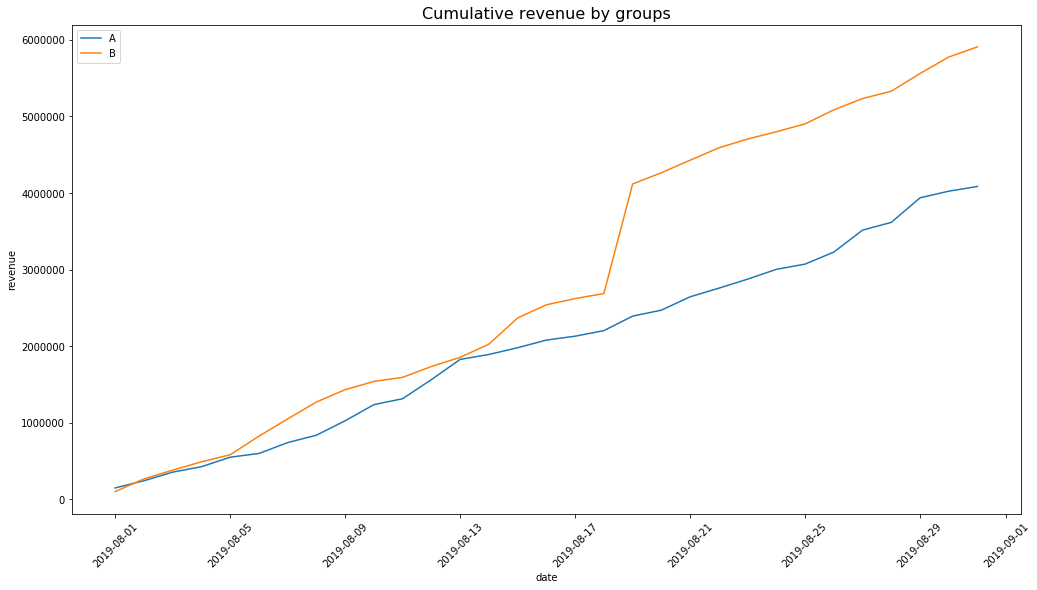

In [20]:
plt.figure(figsize=(17, 9))

plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue'], 
         label='A')

plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue'], 
         label='B')

plt.title('Cumulative revenue by groups', fontsize=16)
plt.xlabel('date')
plt.ylabel('revenue')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Revenue increases throughout the test, which positively characterizes the experiment. At the same time, it is noticeable on the chart that Group B's revenue is growing sharply on some days. This may indicate a sharp increase in orders / expensive purchases or outliers. By the end of the test, **Group B is in the lead in terms of revenue**.

## 2. Cumulative average check by groups

Now let's plot cumulative average check by groups.

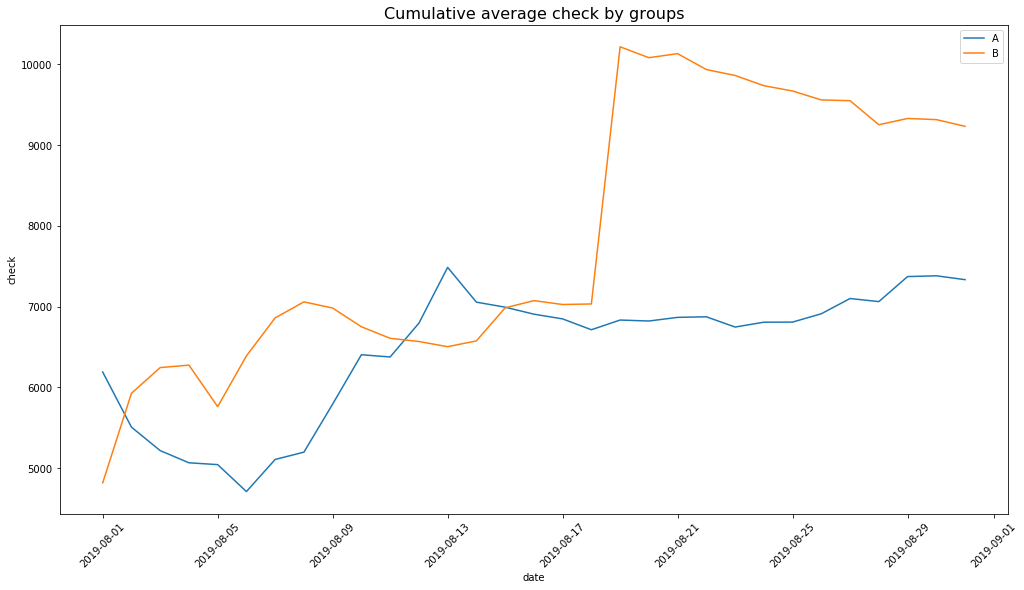

In [21]:
plt.figure(figsize=(17, 9))
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
         label='A')
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
         label='B')
plt.title('Cumulative average check by groups', fontsize=16)
plt.xlabel('date')
plt.ylabel('check')
plt.xticks(rotation=45)
plt.legend()
plt.show()

At the end of experiment, the average check in both groups is averaged, but differs significantly in favor of group B. In the first part of test, there are strong drops and spikes in both groups, which indicates outliers. It is impossible to draw unambiguous conclusions based on the chart, it jumps too much.

### Relative change in cumulative average check of group B to group A

Let's plot relative change in average check. To do this, we'll add a horizontal axis using the `axhline()` method.

In [22]:
mergedCumulativeRevenue = (
    cumulativeRevenueA.merge(cumulativeRevenueB, 
                             left_on='date', 
                             right_on='date', 
                             how='left', 
                             suffixes=['A', 'B'])
)

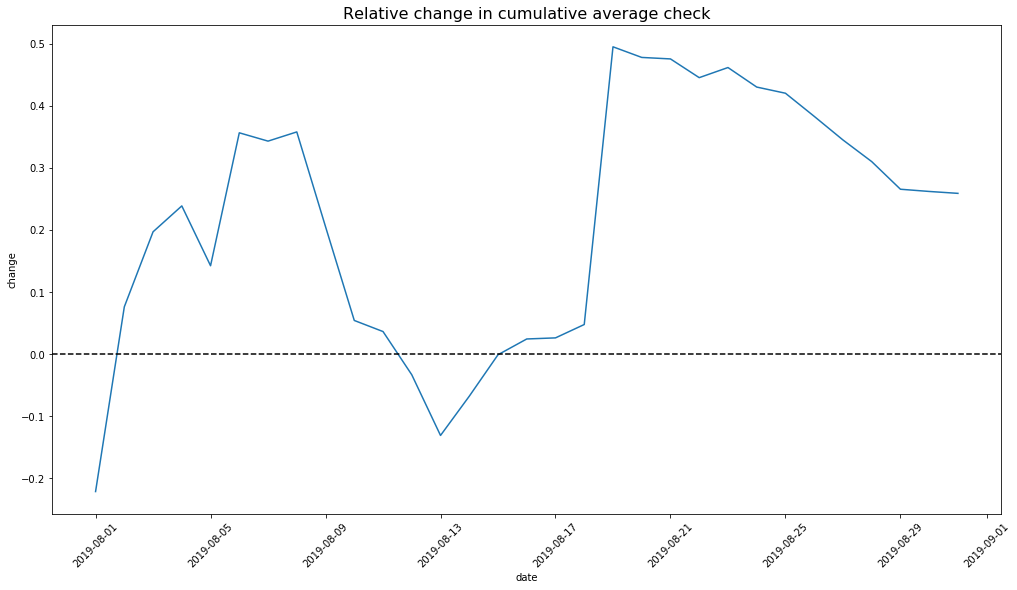

In [23]:
plt.figure(figsize=(17, 9))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('Relative change in cumulative average check', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('change')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

The chart shows several points/dates where difference between groups changes abruptly. This confirms the presence of outliers. We can see which orders dates will be considered outliers.

## 3. Cumulative conversion by groups

In [24]:
# adding column with cumulative conversion  
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [25]:
# splitting the groups  
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

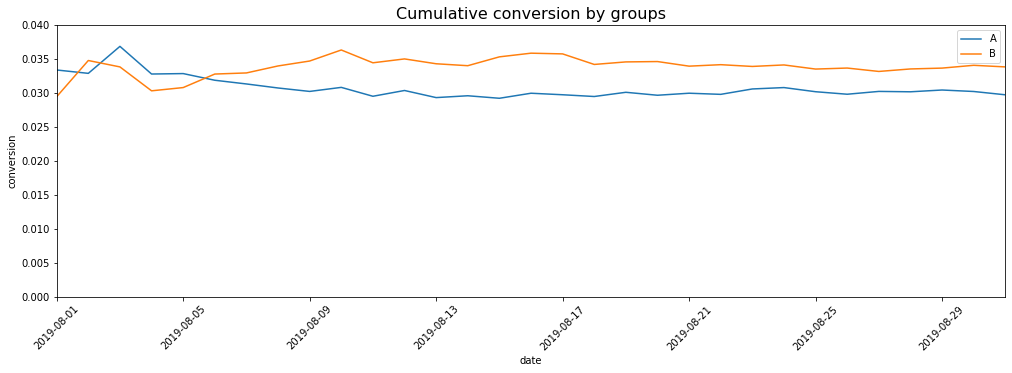

In [26]:
plt.figure(figsize=(17, 5))

plt.plot(cumulativeDataA['date'], 
         cumulativeDataA['conversion'], 
         label='A')
plt.plot(cumulativeDataB['date'], 
         cumulativeDataB['conversion'], 
         label='B')

plt.title('Cumulative conversion by groups', fontsize=16)
plt.xlabel('date')
plt.ylabel('conversion')
plt.xticks(rotation=45)
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0, 0.04])
plt.show()

The chart shows that at first conversion of group B was even smaller than group A's, but then they equalized, and conversion of group B shows a stable increase compared to group A, consolidating at a higher level by the end of the experiment.

### Relative change in cumulative conversion of group B to group A 

In [27]:
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], 
           left_on='date', 
           right_on='date', 
           how='left', 
           suffixes=['A', 'B'])
)

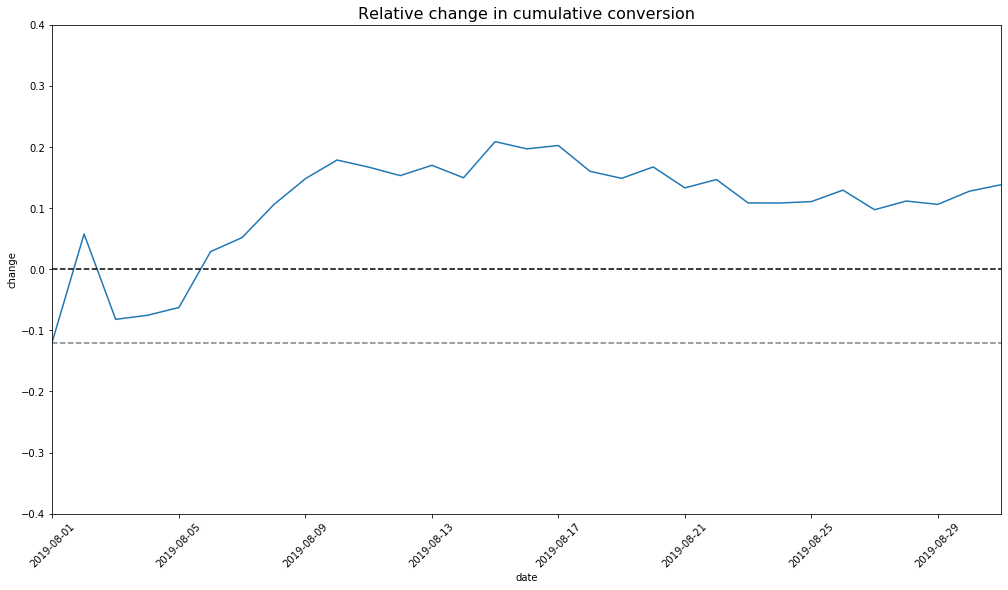

In [28]:
plt.figure(figsize=(17, 9))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1)
plt.title('Relative change in cumulative conversion', fontsize=16)

plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('change')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.12, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.4, 0.4])
plt.show()

At the beginning of the test, group B mostly lost to group A (although there was an increase in one day), but then it gradually began to grow and did not decrease anymore.

## 4. Amount of purchases by groups

Let's calculate the number of orders per user by groups. 

In [29]:
ordersByUsersA = (
    orders[orders['group'] == "A"]
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersA.sort_values(by='orders', ascending=False)

,visitorId,orders
499,4256040402,7
227,2038680547,5
278,2458001652,5
269,2378935119,4
18,199603092,4
...,...,...
167,1426761187,1
166,1422773200,1
165,1422476412,1
164,1414758703,1


In [30]:
ordersByUsersB = (
    orders[orders['group'] == "B"]
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsersB.columns = ['visitorId', 'orders']

ordersByUsersB.sort_values(by='orders', ascending=False)

,visitorId,orders
340,2458001652,6
326,2378935119,5
501,3717692402,4
514,3803269165,4
580,4256040402,4
...,...,...
190,1396482013,1
189,1395236619,1
188,1390677121,1
187,1388838483,1


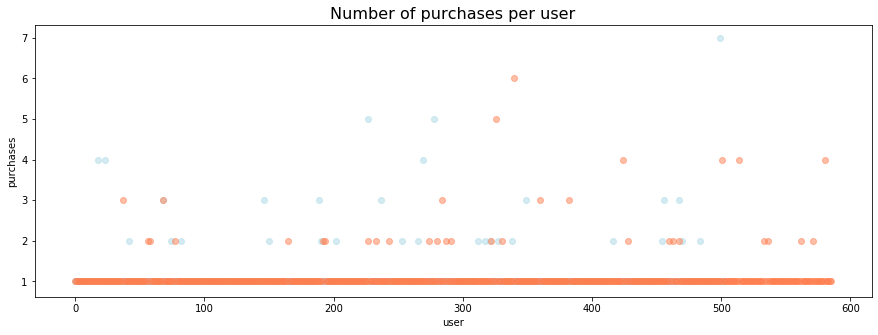

In [31]:
x1_values = pd.Series(range(0,len(ordersByUsersA)))
x2_values = pd.Series(range(0,len(ordersByUsersB)))


plt.figure(figsize=(15, 5))

plt.scatter(x1_values, ordersByUsersA['orders'],c='lightblue', alpha=.5)
plt.scatter(x2_values, ordersByUsersB['orders'], c='coral', alpha=.5)

plt.title('Number of purchases per user', fontsize=16)
plt.xlabel('user')
plt.ylabel('purchases')
plt.show()

There are quite a lot of orders in amount of > 4, while several users have made 11 orders each. This can certainly be considered as outliers.

### 95th and 99th percentiles of purchases amount per user

In [32]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

In [33]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


No more than 5% of users have made more than 2 orders. And no more than 1% - more than 4 orders. To test statistical hypothesis on clean data, we will cut off users with more than 4 orders (2 seems to be quite a normal parameter).

## 5. User spendings on purchases 

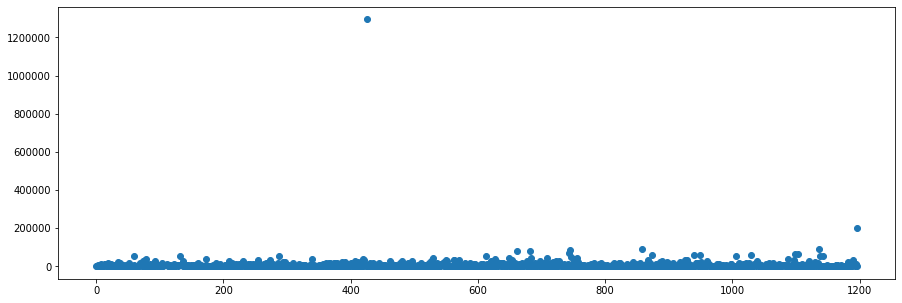

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue']) 
plt.show()

Although there are not many of them, but expensive orders are still on the chart.

###  95th and 99th percentiles of spendings per user¶

In [35]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


No more than 5% of purchases have a check more than 28000 rubles. And 1% of purchases more than 58233 rubles. As with amount of purchases, let's remove more than 1% of outliers and set 50000 rubles as a determiner for an expensive purchase.

## 6. Statistical significance of differences 

### Differences in conversion between groups based on raw data 

At this stage of analysis we looked at the charts based on A/B test results and saw that there are outliers in data. We also established approximate limits for outliers. Now let's calculate the statistical significance of differences in conversion and average check between groups based on "raw" and "clean" data. But first prepare the datasets.

In [36]:
# number of site visitors in group A by days
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [37]:
# cumulative number of visitors for each next day
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [38]:
# the same with group B  
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [39]:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [40]:
# finding number of purchaces and revenue amount for each date in group A 
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique', 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [41]:
# cumulative number of purchaces and revenue amount for each next day  
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [42]:
# the same with group B  
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique', 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [43]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

Let's merge all dataframes in one table.

In [44]:
df = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

We already have `ordersByUsersA` and `orderByUsersB` dataframes with data divided into groups. Using them we'll have `sampleA` and `sampleB` in which users with purchases correspond with the number of purchases. And for users with no orders we'll have zeros. This is necessary to prepare the samples for verification by **Mann-Whitney U test**.

In [45]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [46]:
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Let's test the null hypothesis formulated as follows: `There are no significant difference between conversions in two groups`. The alternative hypothesis would sound like: `There is a significant difference between conversions in two groups`. Level of statistical significance is 0.5.

In [47]:
print("P-value is {0:.4f}".format(
    stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

P-value is 0.0168


In [48]:
print("Relative increase in conversion rate of group B equals to {0:.3f}".format(
    (df['ordersPerDateB'].sum()/df['visitorsPerDateB'].sum())
    /(df['ordersPerDateA'].sum()/df['visitorsPerDateA'].sum())-1))

Relative increase in conversion rate of group B equals to 0.138


P-value is less than 0.05, which means that we reject the null hypothesis. Raw data suggest that there is significant difference in conversion rates of groups A and B. **The relative increase in conversion rate of group B is 13.8%**.

### Differences in average check between groups based on raw data

To find statistical significance of the differences in average check between two groups, let's pass to `mannwhitneyu()` test data on revenue. Let's also find the relative change in average check between groups.

Let's test the null hypothesis formulated as follows: `There are no significant difference between average check in two groups`. The alternative hypothesis would sound like: `There is a significant difference between average check in two groups`. Level of statistical significance is 0.5.

In [49]:
print('P-value is {0:.3f}'.format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                       orders[orders['group']=='B']['revenue'], 
                       alternative='two-sided')[1]))

P-value is 0.729


In [50]:
print('Relative increase in average check is {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()
    /orders[orders['group']=='A']['revenue'].mean()-1))

Relative increase in average check is 0.259


P-value is more than 0.05, which means that we don't reject the null hypothesis (there is no significant difference in average check of groups A and B). At the same time relative increase in **B's average check is 25.9%**. So we need to test the hypothesis one more time on clean data.

### Differences in conversion between groups based on clean data

Previously we discovered that 5% of users made more than 2 orders, and 1% of users made more than 4 orders. And also that 5% of orders have average check more than 28000 rubles, and 1% - more than 58233 rubles.

Let's consider outliers those users who have made at least 4 orders or paid more than 50000 rubles. So we'll remove 1% queries and collect users in `abnormalUsers` dataset.

In [51]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId'],
    ],
    axis=0,
)

In [52]:
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']

In [53]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [54]:
abnormalUsers.shape

(21,)

There were 21 abnormal users (outliers). Now let's evaluate how their actions affected the test results - recalculate the statistical significance of the differences on clean data.

In [55]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [56]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Let's test one more time the null hypothesis formulated as follows: `There are no significant difference between conversions in two groups`. The alternative hypothesis would sound like: `There is a significant difference between conversions in two groups`.

In [57]:
print("P-value is {0:.4f}".format(
    stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))

P-value is 0.0119


In [58]:
print('Relative increase of group B conversion rate equals {0:.3f}'.format(
    sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Relative increase of group B conversion rate equals 0.160


P-value is less than 0.05. So we reject the null hypothesis. Clean data confirm that there is difference in conversion rate in groups A and B. The relative **increase in conversion rate of group B is 16%**.

### Differences in average check between groups based on clean data

Let's see if something will look different on clean data. The null hypothesis formulated as follows: `There are no significant difference between average check in two groups`. The alternative hypothesis would sound like: `There is a significant difference between average check in two groups`. 

In [59]:
print(
    'P-value is {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative='two-sided'
        )[1]
    )
)

P-value is 0.715


In [60]:
print(
    "Relative change in average check is {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Relative change in average check is 0.032


P-value is again more than 0.05. So there is no reason to reject the null hypothesis. There is no difference in average check. At the same time, the average check of group B on clean data decreased significantly (from 25.9% to 3.2%).

## Conclusion

So the results of A/B test are the following:

- There is statistically significant difference in conversion rate in two groups, both on raw and clean data. 
- The relative increase in conversion rate of group B on clean data is 16%.
- There is no statistically significant difference in average check in two groups, which is confirmed on by both raw and clean data. 
- After we removed the outliers, the increase in average check dropped from 25.9% (raw data) to 3.2% (clean data, no outliers).
- The chart with conversion rate by group also showed that group B has better results than group A.
- **Thus, change made on the website allow to increase revenue by improving conversion rate but not by increasing average check**.

Recommended: 
- To stop A/B test, consider test to be successful (group B shows better conversion rate).